In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # for plot visualization
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import re

import warnings

# ignoring all the warnings
warnings.filterwarnings("ignore")



In [3]:
train_df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/titanic_train.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Handling Missing Values

def find_missing_record(df, type):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (total/df.isnull().count()).sort_values(ascending=False)
    missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'], sort=False)
    missing_df = missing_df[missing_df.Total > 0]
    
    plt.subplots(figsize=[12,5])
    plot_inst = sns.barplot(x=missing_df.index, y=missing_df.Total)
    plot_inst.set_title(f'{type} missing record count')
    
    return missing_df

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


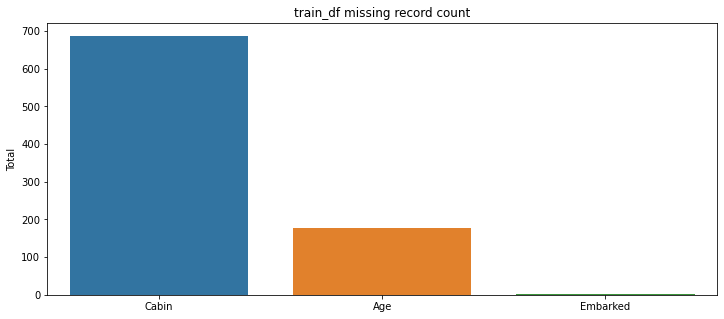

In [7]:
find_missing_record(train_df, 'train_df')

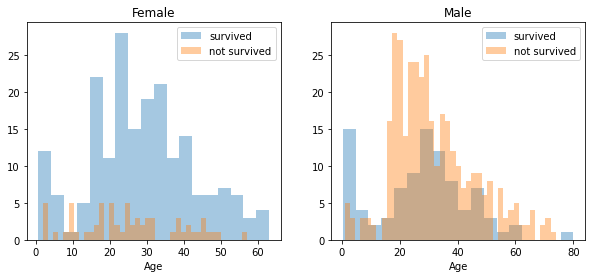

In [8]:
survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

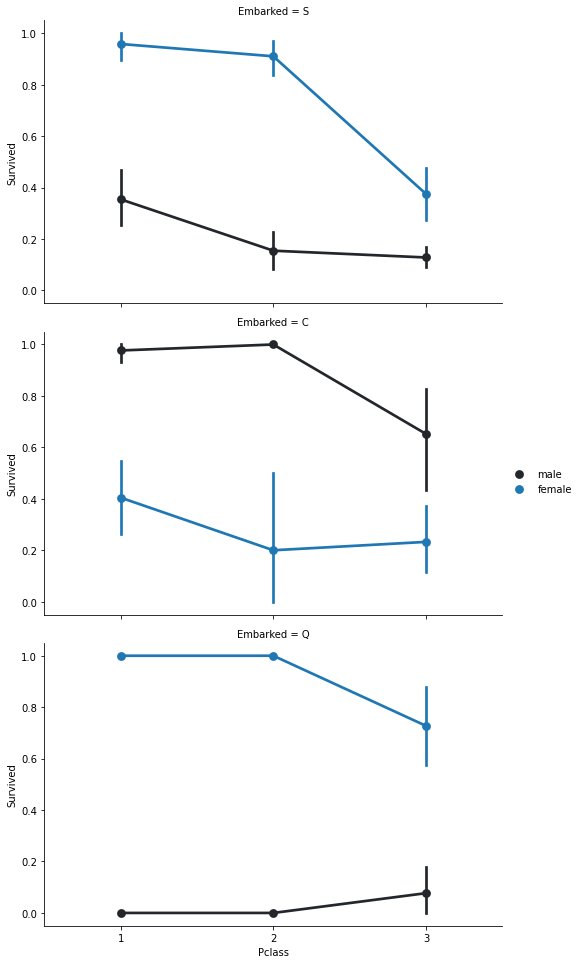

In [9]:
# Embarked, Pclass and Sex:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

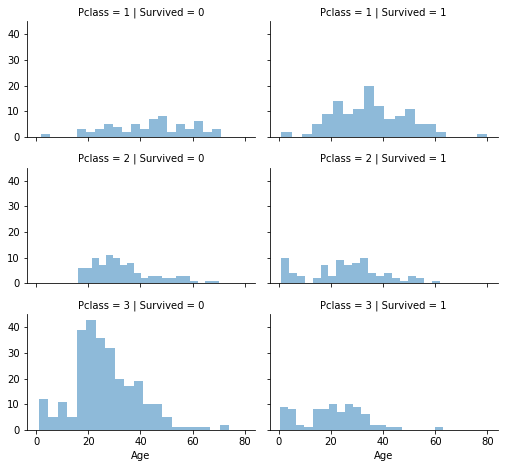

In [10]:
# PClass, Survival and Age Group

grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

<AxesSubplot:xlabel='Embarked', ylabel='count'>

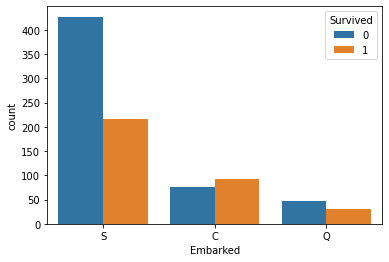

In [11]:
sns.countplot(x='Embarked', data=train_df, hue='Survived')

In [12]:
def fill_missing_values(df):
    df.Age = np.ceil(df.Age.fillna(df.Age.median())).astype(int)
    df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])
    df.Fare = np.ceil(df.Fare.fillna(df.Fare.mean())).astype(int)

    return df

In [13]:
train_df = fill_missing_values(train_df)

In [15]:
# Creating new feature FamilySize
train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1

In [16]:
train_df['FarePerHead'] = (train_df.Fare/train_df.FamilySize).astype(int)
train_df['IsAlone'] = train_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
train_df['AgeGroup'] = train_df.Age.apply(lambda x: 'kid' if x<13 else 'teen' if x<20 else 'adult' if x<41 else 'old')

In [17]:
# Create new feature called Title
def add_title(df):
    df['Title'] = df.Name.apply(lambda x: re.search('(?<=, )\w+', x).group(0))
    df.Title.replace(to_replace=['Ms', 'Lady', 'the', 'Dona'], value='Mrs', inplace=True)
    df.Title.replace(to_replace=['Mme', 'Mlle'], value='Miss', inplace=True)
    df.Title.replace(to_replace=['Jonkheer', 'Sir', 'Capt', 'Don', 'Col', 'Major', 'Rev', 'Dr'], value='Mr', inplace=True)
    return df

In [18]:
train_df = add_title(train_df)

In [19]:
# Handle Categorical variables
def handle_categorical_variables(df):
    df = pd.get_dummies(df, drop_first=True, columns=['Sex', 'Embarked'])
    df.AgeGroup = LabelEncoder().fit_transform(df.AgeGroup)
    df.Title = LabelEncoder().fit_transform(df.Title)
    return df

In [20]:
train_df = handle_categorical_variables(train_df)
train_df.drop(labels=['PassengerId','Name','Ticket', 'Cabin'], axis=1, inplace=True)
train_df.sample(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,FarePerHead,IsAlone,AgeGroup,Title,Sex_male,Embarked_Q,Embarked_S
472,1,2,33,1,2,28,4,7,0,0,3,0,0,1
742,1,1,21,2,2,263,5,52,0,0,1,0,0,0
613,0,3,28,0,0,8,1,8,1,0,2,1,1,0
675,0,3,18,0,0,8,1,8,1,3,2,1,0,1
25,1,3,38,1,5,32,7,4,0,0,3,0,0,1
611,0,3,28,0,0,8,1,8,1,0,2,1,0,1
645,1,1,48,1,0,77,2,38,0,2,2,1,0,0
361,0,2,29,1,0,28,2,14,0,0,2,1,0,0
367,1,3,28,0,0,8,1,8,1,0,3,0,0,0
648,0,3,28,0,0,8,1,8,1,0,2,1,0,1


In [21]:
# global random_state value
rand_state_ = 42
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Survived'], axis=1), train_df.Survived, test_size=0.3, random_state=rand_state_)


In [23]:
class EvaluateClassifier():
    def __init__(self):
        self.classifiers = {}

    def evaluate_model(self, modelName, train_predictions, test_predictions):
        self.classifiers[modelName] = {
            'train_score': accuracy_score(y_train, train_predictions),            
            'test_score': accuracy_score(y_test, test_predictions)
        }

    def fit_and_predict_using_RandomSearchCV(self, classifier, grid_params):
        random_cv_model = RandomizedSearchCV(estimator=classifier, param_distributions=grid_params, cv=10)
        random_cv_model.fit(X_train, y_train)
        self.evaluate_model(classifier.__class__.__name__, random_cv_model.predict(X_train), random_cv_model.predict(X_test))
        self.classifiers[classifier.__class__.__name__]['estimator'] = random_cv_model.estimator
        return self.classifiers[classifier.__class__.__name__]

    def voting_classifier(self, classifier_names):
        selected_classifiers = [(classifier_name, self.classifiers[classifier_name]['estimator']) for classifier_name in classifier_names]
        voting_classifier = VotingClassifier(estimators=selected_classifiers, voting='soft')
        voting_classifier.fit(X_train, y_train)
        self.evaluate_model(voting_classifier.__class__.__name__, voting_classifier.predict(X_train), voting_classifier.predict(X_test))
        self.classifiers[voting_classifier.__class__.__name__]['estimator'] = voting_classifier
        return self.classifiers[voting_classifier.__class__.__name__]
    

In [24]:
eval_classifier = EvaluateClassifier()

In [25]:
# Decision Tree
dt_grid_param = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt'],
    'random_state': [rand_state_]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(DecisionTreeClassifier(), dt_grid_param)

{'train_score': 0.8202247191011236,
 'test_score': 0.8022388059701493,
 'estimator': DecisionTreeClassifier()}

In [26]:
# Random Forest
rf_grid_param = {
    'n_estimators': [10, 30, 60, 90, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt'],
    'random_state': [rand_state_]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(RandomForestClassifier(), rf_grid_param)

{'train_score': 0.8539325842696629,
 'test_score': 0.8208955223880597,
 'estimator': RandomForestClassifier()}

In [27]:
# K nearest neighbors
knn_grid_params = {
    'n_neighbors': [5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(KNeighborsClassifier(), knn_grid_params)

{'train_score': 0.7784911717495987,
 'test_score': 0.7313432835820896,
 'estimator': KNeighborsClassifier()}

In [28]:
# ExtraTreesClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(ExtraTreesClassifier(), {
    'n_estimators': [20, 40, 80],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt']
})

{'train_score': 0.9518459069020867,
 'test_score': 0.7947761194029851,
 'estimator': ExtraTreesClassifier()}

In [29]:
# RidgeClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(RidgeClassifier(), {
    'alpha': [0.8, 1, 7, 13, 17],
    'random_state': [rand_state_]
})

{'train_score': 0.797752808988764,
 'test_score': 0.7985074626865671,
 'estimator': RidgeClassifier()}

In [30]:
# GradientBoostingClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(GradientBoostingClassifier(), {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [100, 120, 150],
    'random_state': [rand_state_],
    'min_samples_split': [2, 3, 4],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4]
})

{'train_score': 0.9325842696629213,
 'test_score': 0.8208955223880597,
 'estimator': GradientBoostingClassifier()}

In [31]:
score_df = pd.DataFrame([{'ModelName': name, 'Test Score': props['test_score'], 'Training Score': props['train_score']} for name, props in eval_classifier.classifiers.items()])
score_df.set_index('ModelName')

,Test Score,Training Score
ModelName,,
DecisionTreeClassifier,0.802239,0.820225
RandomForestClassifier,0.820896,0.853933
KNeighborsClassifier,0.731343,0.778491
ExtraTreesClassifier,0.794776,0.951846
RidgeClassifier,0.798507,0.797753
GradientBoostingClassifier,0.820896,0.932584
